In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import *

from datetime import datetime
from tqdm import tqdm

In [2]:
data = pd.read_csv('ETH_1H.csv' , parse_dates=['Date'] , index_col=['Date'])
data.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2020-04-16 00:00:00,1586995200000,ETHUSD,152.94,152.94,150.39,150.39,650.188125
2020-04-15 23:00:00,1586991600000,ETHUSD,155.81,155.81,151.39,152.94,4277.567299
2020-04-15 22:00:00,1586988000000,ETHUSD,157.18,157.30,155.32,155.81,106.337279
2020-04-15 21:00:00,1586984400000,ETHUSD,158.04,158.31,157.16,157.18,55.244131
2020-04-15 20:00:00,1586980800000,ETHUSD,157.10,158.10,156.87,158.04,144.262622


In [3]:
data = data.sort_index()

In [4]:
data.head(-5)

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2016-05-09 13:00:00,1462798800,ETHUSD,0.00,12.00,0.00,9.55,432.562115
2016-05-09 14:00:00,1462802400,ETHUSD,9.55,10.00,9.55,10.00,235.774075
2016-05-09 15:00:00,1462806000,ETHUSD,10.00,10.00,9.99,9.99,10.973567
2016-05-09 16:00:00,1462809600,ETHUSD,9.99,9.99,9.79,9.83,62.379450
2016-05-09 17:00:00,1462813200,ETHUSD,9.83,9.83,9.48,9.49,329.553213
...,...,...,...,...,...,...,...
2020-04-15 15:00:00,1586962800000,ETHUSD,157.12,157.15,155.81,155.81,303.839541
2020-04-15 16:00:00,1586966400000,ETHUSD,155.81,157.52,155.74,157.12,430.083035
2020-04-15 17:00:00,1586970000000,ETHUSD,157.12,157.78,156.90,157.48,156.552221


In [5]:
data.shape

(34497, 7)

In [6]:
data.duplicated().sum()

np.int64(0)

In [7]:
data = data.drop(columns=['Unix Timestamp' , 'Symbol'])

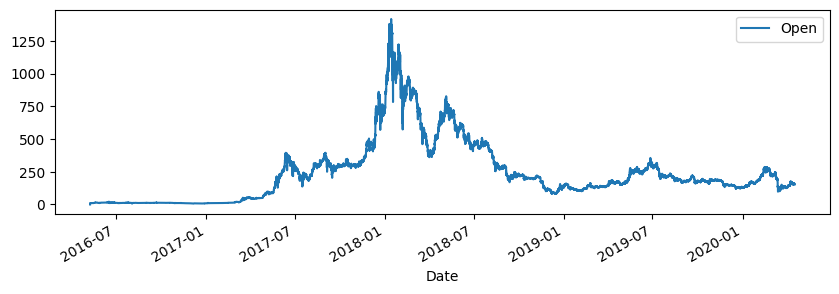

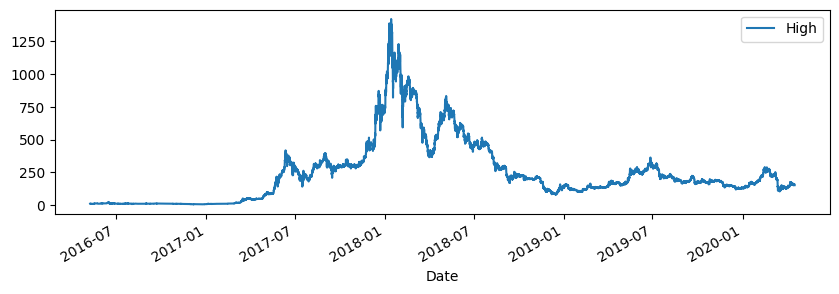

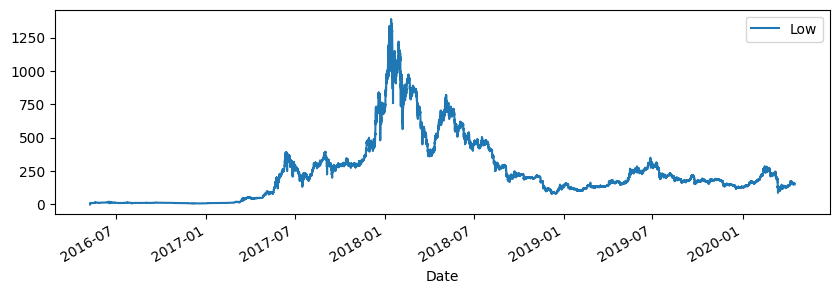

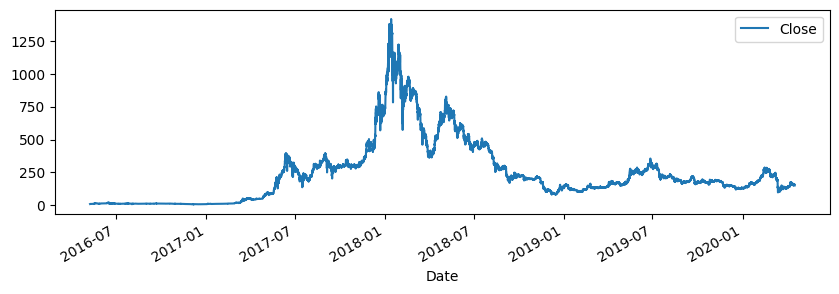

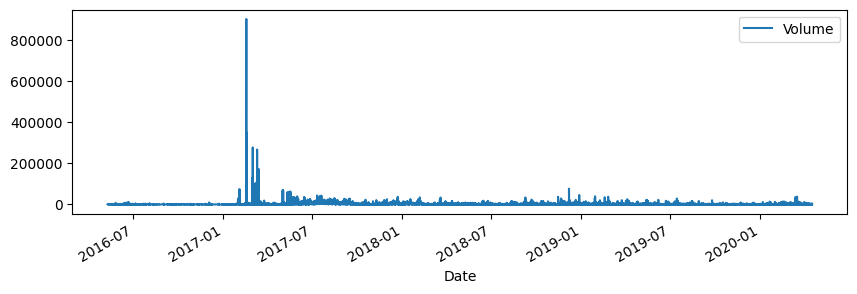

In [8]:
for i in data:
    plt.figure(figsize=(10,3))
    data[i].plot(legend=i)
    plt.show()

In [9]:
def create_f(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    return df

In [10]:
df = create_f(data)

<Axes: >

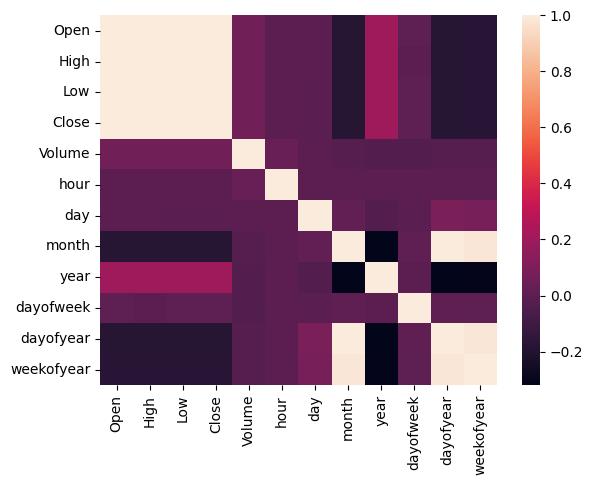

In [11]:
sns.heatmap(df.corr())

In [12]:
close = df.iloc[:,3]
windows=[]
target=[]
length = 240
for i in (range(len(close)-length)):
    x = close.iloc[i:i+length]
    y = close.iloc[i+length]
    windows.append(x)
    target.append(y)
    
    
windows=np.array(windows)
target=np.array(target).reshape(-1,1)

In [13]:
sc = MinMaxScaler()
windows_sc = sc.fit_transform(windows)
target_sc = sc.fit_transform(target)

windows_sc = windows_sc.reshape((len(windows_sc),length,1))

In [14]:
split = int(0.8*len(windows_sc))

X_train = windows_sc[:split,:,:]
X_test = windows_sc[split:,:,:]
y_train = target_sc[:split,:]
y_test = target_sc[split:,:]

In [15]:
print(X_train.shape , y_train.shape)

(27405, 240, 1) (27405, 1)


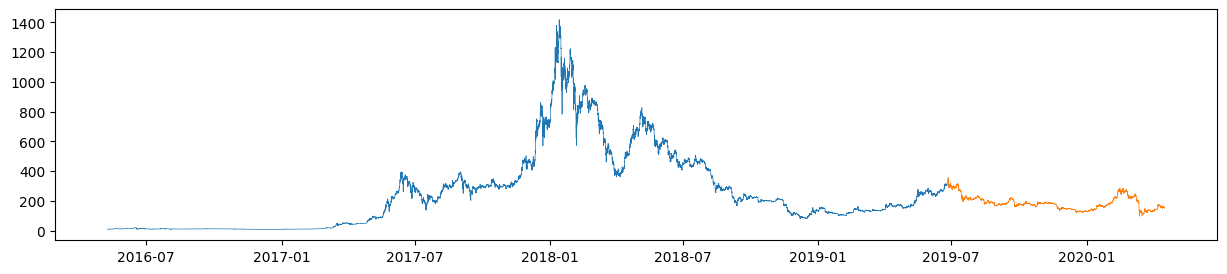

In [16]:
plt.figure(figsize=(15,3))
plt.plot(df['Close'][:split],label='Train',linewidth=0.5)
plt.plot(df['Close'][split:],label='Test',linewidth=0.5)

In [18]:
model = Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

D:\projects\Data Science\DiamondSellPrice\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train,y_train, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 79s 287ms/step - loss: 2.1394e-04
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 83s 300ms/step - loss: 2.0713e-04
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - loss: 1.8615e-04
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 83s 302ms/step - loss: 1.7865e-04
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - loss: 1.8404e-04


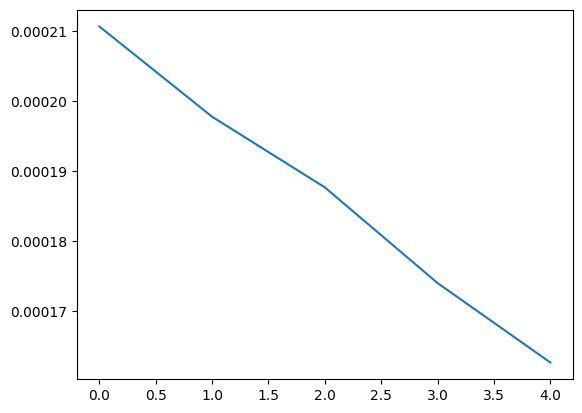

In [22]:
plt.plot(model.history.history['loss'])

In [23]:
pred_sc = model.predict(X_test)
pred = sc.inverse_transform(pred_sc)
y_test_ic = sc.inverse_transform(y_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step


The Coefficient of determination (R-squared) = 0.980


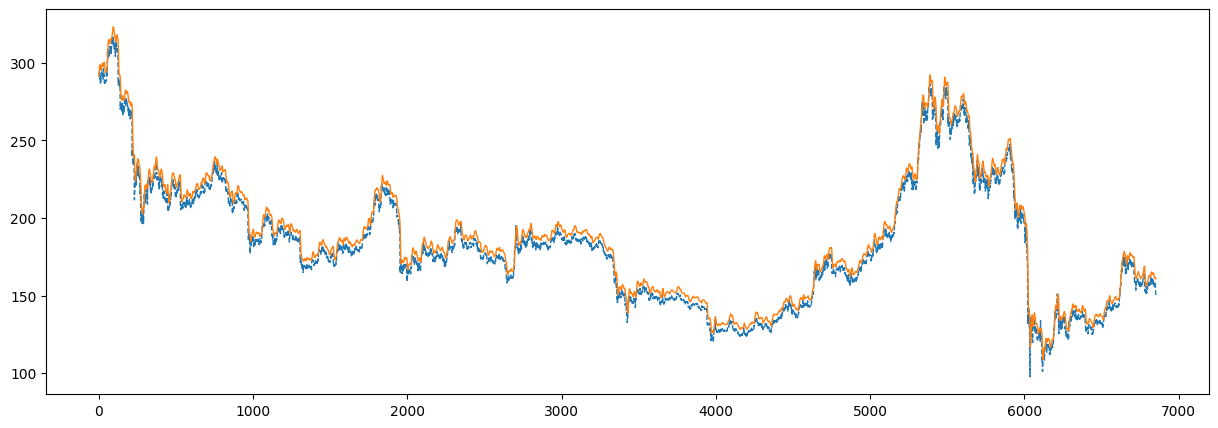

In [24]:
print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2_score(pred,y_test_ic)))

plt.figure(figsize=(15,5))
plt.plot(y_test_ic,'--',label='Actual',linewidth=1)
plt.plot(pred,label='Predicted',linewidth=1)

In [25]:
# Future Prediction
model = Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

D:\projects\Data Science\DiamondSellPrice\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
X = windows_sc
y = target_sc

model.fit(X,y, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 106s 304ms/step - loss: 0.0042
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 102s 299ms/step - loss: 2.2764e-04
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 105s 307ms/step - loss: 2.0906e-04
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 104s 303ms/step - loss: 1.8266e-04
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 104s 304ms/step - loss: 1.6890e-04


In [37]:
str_d1 = '2019/04/16'
str_d2 = '2019/05/16'

# convert string to date object
d1 = datetime.strptime(str_d1, "%Y/%m/%d")
d2 = datetime.strptime(str_d2, "%Y/%m/%d")

delta = d2-d1
steps_in_future = delta.days * 24
print("Steps in future: ",steps_in_future)

Steps in future:  720


In [38]:
f_wind=windows_sc[-1]
f_tar=target_sc[-1]
new=[]

for i in tqdm(range(steps_in_future)):
    curr = np.append(f_wind[1:],[f_tar]).reshape(-1,1)
    next_pred = model.predict(curr.reshape(1,length,1))
    new.append(next_pred[0][0])
    f_wind = curr
    f_tar=next_pred

  0%|                                                                                          | 0/720 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  0%|                                                                                  | 1/720 [00:00<03:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|▎                                                                                 | 3/720 [00:00<01:40,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  1%|▍                                                                                 | 4/720 [00:00<01:35,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|▋                                                                                 | 6/720 [00:00<01:20,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|▉                                                                                 | 8/720 [00:00<01:10, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|█▏                                                                               | 10/720 [00:01<01:04, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|█▎                                                                               | 12/720 [00:01<01:01, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|█▌                                                                               | 14/720 [00:01<00:58, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|█▊                                                                               | 16/720 [00:01<00:57, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|██                                                                               | 18/720 [00:01<00:56, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|██▎                                                                              | 20/720 [00:01<00:56, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  3%|██▍                                                                              | 22/720 [00:02<00:55, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|██▋                                                                              | 24/720 [00:02<00:55, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|██▉                                                                              | 26/720 [00:02<00:56, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|███▏                                                                             | 28/720 [00:02<00:55, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|███▍                                                                             | 30/720 [00:02<00:55, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|███▌                                                                             | 32/720 [00:02<00:57, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|███▊                                                                             | 34/720 [00:03<00:58, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|████                                                                             | 36/720 [00:03<01:02, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|████▎                                                                            | 38/720 [00:03<01:03, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|████▌                                                                            | 40/720 [00:03<01:01, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|████▋                                                                            | 42/720 [00:03<01:01, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  6%|████▉                                                                            | 44/720 [00:03<00:58, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|█████▏                                                                           | 46/720 [00:04<00:57, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|█████▍                                                                           | 48/720 [00:04<00:55, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|█████▋                                                                           | 50/720 [00:04<00:53, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|█████▊                                                                           | 52/720 [00:04<00:51, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|██████                                                                           | 54/720 [00:04<00:50, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|██████▎                                                                          | 56/720 [00:04<00:49, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|██████▌                                                                          | 58/720 [00:04<00:49, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|██████▊                                                                          | 60/720 [00:05<00:48, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  9%|██████▉                                                                          | 62/720 [00:05<00:47, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|███████▏                                                                         | 64/720 [00:05<00:46, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|███████▍                                                                         | 66/720 [00:05<00:46, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|███████▋                                                                         | 68/720 [00:05<00:46, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|███████▉                                                                         | 70/720 [00:05<00:46, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████████                                                                         | 72/720 [00:05<00:48, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|████████▎                                                                        | 74/720 [00:06<00:49, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|████████▌                                                                        | 76/720 [00:06<00:48, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|████████▊                                                                        | 78/720 [00:06<00:47, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█████████                                                                        | 80/720 [00:06<00:47, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█████████▏                                                                       | 82/720 [00:06<00:47, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█████████▍                                                                       | 84/720 [00:06<00:47, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█████████▋                                                                       | 86/720 [00:07<00:46, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█████████▉                                                                       | 88/720 [00:07<00:47, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|██████████▏                                                                      | 90/720 [00:07<00:52, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|██████████▎                                                                      | 92/720 [00:07<00:50, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|██████████▌                                                                      | 94/720 [00:07<00:48, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|██████████▊                                                                      | 96/720 [00:07<00:47, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|███████████                                                                      | 98/720 [00:07<00:47, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|███████████                                                                     | 100/720 [00:08<00:46, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|███████████▎                                                                    | 102/720 [00:08<00:45, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|███████████▌                                                                    | 104/720 [00:08<00:46, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|███████████▊                                                                    | 106/720 [00:08<00:45, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|████████████                                                                    | 108/720 [00:08<00:48, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|████████████▏                                                                   | 110/720 [00:08<00:52, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|████████████▍                                                                   | 112/720 [00:09<00:50, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|████████████▋                                                                   | 114/720 [00:09<00:48, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|████████████▉                                                                   | 116/720 [00:09<00:47, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█████████████                                                                   | 118/720 [00:09<00:46, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█████████████▎                                                                  | 120/720 [00:09<00:46, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█████████████▌                                                                  | 122/720 [00:09<00:46, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█████████████▊                                                                  | 124/720 [00:10<00:44, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|██████████████                                                                  | 126/720 [00:10<00:49, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|██████████████▏                                                                 | 128/720 [00:10<00:53, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 18%|██████████████▍                                                                 | 130/720 [00:10<00:56, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|██████████████▋                                                                 | 132/720 [00:10<00:54, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|██████████████▉                                                                 | 134/720 [00:10<00:54, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|███████████████                                                                 | 136/720 [00:11<00:50, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|███████████████▎                                                                | 138/720 [00:11<00:48, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|███████████████▌                                                                | 140/720 [00:11<00:46, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|███████████████▊                                                                | 142/720 [00:11<00:44, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|████████████████                                                                | 144/720 [00:11<00:43, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|████████████████▏                                                               | 146/720 [00:11<00:43, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████████████▍                                                               | 148/720 [00:12<00:44, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|████████████████▋                                                               | 150/720 [00:12<00:46, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|████████████████▉                                                               | 152/720 [00:12<00:46, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|█████████████████                                                               | 154/720 [00:12<00:44, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|█████████████████▎                                                              | 156/720 [00:12<00:44, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|█████████████████▌                                                              | 158/720 [00:12<00:43, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 22%|█████████████████▊                                                              | 160/720 [00:12<00:42, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██████████████████                                                              | 162/720 [00:13<00:41, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██████████████████▏                                                             | 164/720 [00:13<00:41, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██████████████████▍                                                             | 166/720 [00:13<00:41, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██████████████████▋                                                             | 168/720 [00:13<00:41, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██████████████████▉                                                             | 170/720 [00:13<00:41, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|███████████████████                                                             | 172/720 [00:13<00:40, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|███████████████████▎                                                            | 174/720 [00:14<00:40, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|███████████████████▌                                                            | 176/720 [00:14<00:40, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|███████████████████▊                                                            | 178/720 [00:14<00:39, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|████████████████████                                                            | 180/720 [00:14<00:40, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|████████████████████▏                                                           | 182/720 [00:14<00:40, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|████████████████████▍                                                           | 184/720 [00:14<00:40, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|████████████████████▋                                                           | 186/720 [00:14<00:40, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|████████████████████▉                                                           | 188/720 [00:15<00:40, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 26%|█████████████████████                                                           | 190/720 [00:15<00:39, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|█████████████████████▎                                                          | 192/720 [00:15<00:39, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|█████████████████████▌                                                          | 194/720 [00:15<00:40, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 27%|█████████████████████▊                                                          | 196/720 [00:15<00:40, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██████████████████████                                                          | 198/720 [00:15<00:39, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██████████████████████▏                                                         | 200/720 [00:15<00:39, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██████████████████████▍                                                         | 202/720 [00:16<00:39, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 28%|██████████████████████▋                                                         | 204/720 [00:16<00:41, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 29%|██████████████████████▉                                                         | 206/720 [00:16<00:42, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|███████████████████████                                                         | 208/720 [00:16<00:41, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|███████████████████████▎                                                        | 210/720 [00:16<00:40, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|███████████████████████▌                                                        | 212/720 [00:16<00:39, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███████████████████████▊                                                        | 214/720 [00:17<00:40, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|████████████████████████                                                        | 216/720 [00:17<00:40, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|████████████████████████▏                                                       | 218/720 [00:17<00:38, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|████████████████████████▍                                                       | 220/720 [00:17<00:38, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|████████████████████████▋                                                       | 222/720 [00:17<00:37, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|████████████████████████▉                                                       | 224/720 [00:17<00:37, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|█████████████████████████                                                       | 226/720 [00:18<00:36, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|█████████████████████████▎                                                      | 228/720 [00:18<00:36, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|█████████████████████████▌                                                      | 230/720 [00:18<00:35, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|█████████████████████████▊                                                      | 232/720 [00:18<00:36, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|██████████████████████████                                                      | 234/720 [00:18<00:35, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|██████████████████████████▏                                                     | 236/720 [00:18<00:35, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|██████████████████████████▍                                                     | 238/720 [00:18<00:35, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|██████████████████████████▋                                                     | 240/720 [00:19<00:35, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 34%|██████████████████████████▉                                                     | 242/720 [00:19<00:35, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 34%|███████████████████████████                                                     | 244/720 [00:19<00:34, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███████████████████████████▎                                                    | 246/720 [00:19<00:34, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███████████████████████████▌                                                    | 248/720 [00:19<00:34, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███████████████████████████▊                                                    | 250/720 [00:19<00:34, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|████████████████████████████                                                    | 252/720 [00:19<00:34, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|████████████████████████████▏                                                   | 254/720 [00:20<00:34, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 36%|████████████████████████████▍                                                   | 256/720 [00:20<00:34, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|████████████████████████████▋                                                   | 258/720 [00:20<00:34, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 36%|████████████████████████████▉                                                   | 260/720 [00:20<00:34, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|█████████████████████████████                                                   | 262/720 [00:20<00:33, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|█████████████████████████████▎                                                  | 264/720 [00:20<00:34, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|█████████████████████████████▌                                                  | 266/720 [00:20<00:34, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|█████████████████████████████▊                                                  | 268/720 [00:21<00:33, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|██████████████████████████████                                                  | 270/720 [00:21<00:33, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|██████████████████████████████▏                                                 | 272/720 [00:21<00:33, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|██████████████████████████████▍                                                 | 274/720 [00:21<00:33, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 38%|██████████████████████████████▋                                                 | 276/720 [00:21<00:35, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|██████████████████████████████▉                                                 | 278/720 [00:21<00:36, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███████████████████████████████                                                 | 280/720 [00:22<00:36, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███████████████████████████████▎                                                | 282/720 [00:22<00:34, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███████████████████████████████▌                                                | 284/720 [00:22<00:33, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|███████████████████████████████▊                                                | 286/720 [00:22<00:33, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|████████████████████████████████                                                | 288/720 [00:22<00:31, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████████████████████████████████▏                                               | 290/720 [00:22<00:31, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████████████████████████████████▍                                               | 292/720 [00:22<00:31, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████████████████████████████████▋                                               | 294/720 [00:23<00:31, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████████████████████████████████▉                                               | 296/720 [00:23<00:31, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|█████████████████████████████████                                               | 298/720 [00:23<00:31, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|█████████████████████████████████▎                                              | 300/720 [00:23<00:31, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 42%|█████████████████████████████████▌                                              | 302/720 [00:23<00:30, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|█████████████████████████████████▊                                              | 304/720 [00:23<00:30, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|██████████████████████████████████                                              | 306/720 [00:23<00:30, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|██████████████████████████████████▏                                             | 308/720 [00:24<00:29, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|██████████████████████████████████▍                                             | 310/720 [00:24<00:29, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|██████████████████████████████████▋                                             | 312/720 [00:24<00:30, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|██████████████████████████████████▉                                             | 314/720 [00:24<00:30, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|███████████████████████████████████                                             | 316/720 [00:24<00:30, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|███████████████████████████████████▎                                            | 318/720 [00:24<00:29, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|███████████████████████████████████▌                                            | 320/720 [00:25<00:30, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|███████████████████████████████████▊                                            | 322/720 [00:25<00:29, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████████████████████████████████████                                            | 324/720 [00:25<00:29, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████████████████████████████████████▏                                           | 326/720 [00:25<00:29, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████████████████████████████████████▍                                           | 328/720 [00:25<00:28, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 46%|████████████████████████████████████▋                                           | 330/720 [00:25<00:27, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 46%|████████████████████████████████████▉                                           | 332/720 [00:25<00:32, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|█████████████████████████████████████                                           | 334/720 [00:26<00:34, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 47%|█████████████████████████████████████▎                                          | 336/720 [00:26<00:37, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|█████████████████████████████████████▌                                          | 338/720 [00:26<00:37, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|█████████████████████████████████████▊                                          | 340/720 [00:26<00:34, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|██████████████████████████████████████                                          | 342/720 [00:26<00:33, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|██████████████████████████████████████▏                                         | 344/720 [00:27<00:31, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|██████████████████████████████████████▍                                         | 346/720 [00:27<00:30, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|██████████████████████████████████████▋                                         | 348/720 [00:27<00:29, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|██████████████████████████████████████▉                                         | 350/720 [00:27<00:29, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 49%|███████████████████████████████████████                                         | 352/720 [00:27<00:28, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|███████████████████████████████████████▎                                        | 354/720 [00:27<00:27, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|███████████████████████████████████████▌                                        | 356/720 [00:27<00:26, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|███████████████████████████████████████▊                                        | 358/720 [00:28<00:26, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████████████████████████████████████████                                        | 360/720 [00:28<00:27, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████████████████████████████████████████▏                                       | 362/720 [00:28<00:28, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|████████████████████████████████████████▍                                       | 364/720 [00:28<00:27, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 51%|████████████████████████████████████████▋                                       | 366/720 [00:28<00:27, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|████████████████████████████████████████▉                                       | 368/720 [00:28<00:27, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████████████████████████████████████████                                       | 370/720 [00:29<00:30, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████████████████████████████████████████▎                                      | 372/720 [00:29<00:29, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████████████████████████████████████████▌                                      | 374/720 [00:29<00:29, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 52%|█████████████████████████████████████████▊                                      | 376/720 [00:29<00:29, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|██████████████████████████████████████████                                      | 378/720 [00:29<00:28, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|██████████████████████████████████████████▏                                     | 380/720 [00:29<00:26, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|██████████████████████████████████████████▍                                     | 382/720 [00:30<00:27, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 53%|██████████████████████████████████████████▋                                     | 384/720 [00:30<00:27, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 54%|██████████████████████████████████████████▉                                     | 386/720 [00:30<00:26, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|███████████████████████████████████████████                                     | 388/720 [00:30<00:25, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 54%|███████████████████████████████████████████▎                                    | 390/720 [00:30<00:24, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|███████████████████████████████████████████▌                                    | 392/720 [00:30<00:25, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 55%|███████████████████████████████████████████▊                                    | 394/720 [00:31<00:24, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|████████████████████████████████████████████                                    | 396/720 [00:31<00:24, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|████████████████████████████████████████████▏                                   | 398/720 [00:31<00:23, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|████████████████████████████████████████████▍                                   | 400/720 [00:31<00:23, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|████████████████████████████████████████████▋                                   | 402/720 [00:31<00:23, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|████████████████████████████████████████████▉                                   | 404/720 [00:31<00:23, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████████████████████████████████████████████                                   | 406/720 [00:31<00:23, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████████████████████████████████████████████▎                                  | 408/720 [00:32<00:22, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████████████████████████████████████████████▌                                  | 410/720 [00:32<00:22, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████████████████████████████████████████████▊                                  | 412/720 [00:32<00:22, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|██████████████████████████████████████████████                                  | 414/720 [00:32<00:21, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|██████████████████████████████████████████████▏                                 | 416/720 [00:32<00:21, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|██████████████████████████████████████████████▍                                 | 418/720 [00:32<00:21, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|██████████████████████████████████████████████▋                                 | 420/720 [00:32<00:21, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|██████████████████████████████████████████████▉                                 | 422/720 [00:33<00:21, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|███████████████████████████████████████████████                                 | 424/720 [00:33<00:21, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|███████████████████████████████████████████████▎                                | 426/720 [00:33<00:20, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|███████████████████████████████████████████████▌                                | 428/720 [00:33<00:20, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|███████████████████████████████████████████████▊                                | 430/720 [00:33<00:20, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 60%|████████████████████████████████████████████████                                | 432/720 [00:33<00:20, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|████████████████████████████████████████████████▏                               | 434/720 [00:33<00:20, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|████████████████████████████████████████████████▍                               | 436/720 [00:34<00:20, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|████████████████████████████████████████████████▋                               | 438/720 [00:34<00:20, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|████████████████████████████████████████████████▉                               | 440/720 [00:34<00:19, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|█████████████████████████████████████████████████                               | 442/720 [00:34<00:19, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|█████████████████████████████████████████████████▎                              | 444/720 [00:34<00:19, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|█████████████████████████████████████████████████▌                              | 446/720 [00:34<00:19, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|█████████████████████████████████████████████████▊                              | 448/720 [00:34<00:19, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|██████████████████████████████████████████████████                              | 450/720 [00:35<00:19, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████████████████████████████████████████████████▏                             | 452/720 [00:35<00:19, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████████████████████████████████████████████████▍                             | 454/720 [00:35<00:19, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████████████████████████████████████████████████▋                             | 456/720 [00:35<00:18, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████▉                             | 458/720 [00:35<00:18, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████                             | 460/720 [00:35<00:18, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|███████████████████████████████████████████████████▎                            | 462/720 [00:35<00:18, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|███████████████████████████████████████████████████▌                            | 464/720 [00:36<00:18, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████▊                            | 466/720 [00:36<00:17, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|████████████████████████████████████████████████████                            | 468/720 [00:36<00:17, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|████████████████████████████████████████████████████▏                           | 470/720 [00:36<00:17, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|████████████████████████████████████████████████████▍                           | 472/720 [00:36<00:17, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|████████████████████████████████████████████████████▋                           | 474/720 [00:36<00:17, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|████████████████████████████████████████████████████▉                           | 476/720 [00:36<00:17, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|█████████████████████████████████████████████████████                           | 478/720 [00:37<00:19, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|█████████████████████████████████████████████████████▎                          | 480/720 [00:37<00:18, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|█████████████████████████████████████████████████████▌                          | 482/720 [00:37<00:18, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|█████████████████████████████████████████████████████▊                          | 484/720 [00:37<00:19, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████████████████████████████████                          | 486/720 [00:37<00:20, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████████████████████████████████████████████████████▏                         | 488/720 [00:37<00:20, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 68%|██████████████████████████████████████████████████████▍                         | 490/720 [00:38<00:20, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████████████████████████████████████████████████████▋                         | 492/720 [00:38<00:20, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████████████████████████████████████████████████████▉                         | 494/720 [00:38<00:19, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|███████████████████████████████████████████████████████                         | 496/720 [00:38<00:19, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|███████████████████████████████████████████████████████▎                        | 498/720 [00:38<00:21, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|███████████████████████████████████████████████████████▌                        | 500/720 [00:39<00:21, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 70%|███████████████████████████████████████████████████████▊                        | 502/720 [00:39<00:22,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|████████████████████████████████████████████████████████                        | 504/720 [00:39<00:21, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|████████████████████████████████████████████████████████▏                       | 506/720 [00:39<00:19, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|████████████████████████████████████████████████████████▍                       | 508/720 [00:39<00:18, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|████████████████████████████████████████████████████████▋                       | 510/720 [00:39<00:17, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|████████████████████████████████████████████████████████▉                       | 512/720 [00:40<00:16, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|█████████████████████████████████████████████████████████                       | 514/720 [00:40<00:15, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 516/720 [00:40<00:15, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 518/720 [00:40<00:15, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 520/720 [00:40<00:16, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|██████████████████████████████████████████████████████████                      | 522/720 [00:40<00:15, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 524/720 [00:41<00:16, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 526/720 [00:41<00:15, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 528/720 [00:41<00:15, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 530/720 [00:41<00:14, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████████████████████████████████████████████████████████                     | 532/720 [00:41<00:14, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 534/720 [00:41<00:14, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 536/720 [00:41<00:14, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 538/720 [00:42<00:14, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 75%|████████████████████████████████████████████████████████████                    | 540/720 [00:42<00:13, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 542/720 [00:42<00:13, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 544/720 [00:42<00:13, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 546/720 [00:42<00:12, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 548/720 [00:42<00:13, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|█████████████████████████████████████████████████████████████                   | 550/720 [00:42<00:12, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 552/720 [00:43<00:12, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 554/720 [00:43<00:12, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 556/720 [00:43<00:12, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|██████████████████████████████████████████████████████████████                  | 558/720 [00:43<00:11, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 560/720 [00:43<00:11, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 562/720 [00:43<00:11, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 564/720 [00:44<00:11, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 566/720 [00:44<00:11, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████                 | 568/720 [00:44<00:10, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 570/720 [00:44<00:10, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 572/720 [00:44<00:10, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 574/720 [00:44<00:10, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████████████████████████████████████████████████████████████                | 576/720 [00:44<00:10, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 578/720 [00:45<00:10, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 580/720 [00:45<00:11, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 582/720 [00:45<00:10, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 584/720 [00:45<00:10, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|█████████████████████████████████████████████████████████████████               | 586/720 [00:45<00:10, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 588/720 [00:45<00:09, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 590/720 [00:45<00:09, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 592/720 [00:46<00:09, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|██████████████████████████████████████████████████████████████████              | 594/720 [00:46<00:09, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 596/720 [00:46<00:09, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 598/720 [00:46<00:08, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 600/720 [00:46<00:08, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 602/720 [00:46<00:08, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████████             | 604/720 [00:46<00:08, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 606/720 [00:47<00:08, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 608/720 [00:47<00:08, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 610/720 [00:47<00:07, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████████████████████████████████████████████████████████████████            | 612/720 [00:47<00:07, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 614/720 [00:47<00:07, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 616/720 [00:47<00:07, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 618/720 [00:47<00:07, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 620/720 [00:48<00:07, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 622/720 [00:48<00:07, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 624/720 [00:48<00:07, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 626/720 [00:48<00:06, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 628/720 [00:48<00:06, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 630/720 [00:48<00:06, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 632/720 [00:48<00:06, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 634/720 [00:49<00:06, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 636/720 [00:49<00:06, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 638/720 [00:49<00:05, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 640/720 [00:49<00:05, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 642/720 [00:49<00:05, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 644/720 [00:49<00:05, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 646/720 [00:50<00:05, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 648/720 [00:50<00:05, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 650/720 [00:50<00:05, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 652/720 [00:50<00:05, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 654/720 [00:50<00:04, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 656/720 [00:50<00:04, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 658/720 [00:50<00:04, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 660/720 [00:51<00:04, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 662/720 [00:51<00:05, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 664/720 [00:51<00:05, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|██████████████████████████████████████████████████████████████████████████      | 666/720 [00:51<00:05,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 668/720 [00:51<00:05, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 670/720 [00:52<00:05,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 671/720 [00:52<00:05,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 673/720 [00:52<00:04, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 675/720 [00:52<00:04, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 677/720 [00:52<00:03, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 679/720 [00:53<00:03, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 681/720 [00:53<00:03, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 683/720 [00:53<00:03, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 685/720 [00:53<00:02, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 687/720 [00:53<00:02, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 689/720 [00:53<00:02, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 691/720 [00:53<00:02, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 693/720 [00:54<00:02, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 695/720 [00:54<00:01, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 697/720 [00:54<00:01, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 699/720 [00:54<00:01, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 701/720 [00:54<00:01, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 703/720 [00:54<00:01, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 705/720 [00:54<00:01, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 707/720 [00:55<00:00, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 709/720 [00:55<00:00, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 711/720 [00:55<00:00, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 713/720 [00:55<00:00, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 715/720 [00:55<00:00, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 717/720 [00:55<00:00, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|███████████████████████████████████████████████████████████████████████████████▉| 719/720 [00:55<00:00, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:56<00:00, 12.85it/s]


In [39]:
new = sc.inverse_transform(np.array(new).reshape(-1,1))

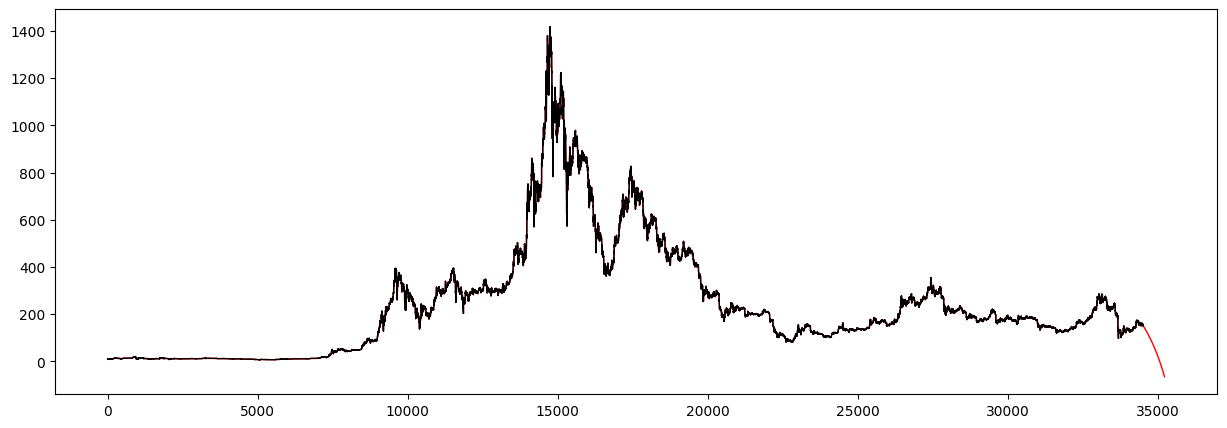

In [40]:
out = []
out = np.append(df.Close.values,new)
plt.figure(figsize=(15,5))
plt.plot(out,linewidth=1,color='red')
plt.plot(df.Close.values,linewidth=1,color='black')
plt.show()

In [41]:
print(len(out),len(df.Close))

35217 34497


In [42]:
import pickle


model.save('model.h5')
filename = 'scaler.pkl'
f = open(filename, 'wb')
pickle.dump(sc,f )
f.close()

In [43]:
with open('window.npy', 'wb') as f:
    np.save(f, windows_sc)
with open('target.npy', 'wb') as f:
    np.save(f, target_sc)